# vebar-A CC calculator
Calculates vebar-A CC cross sections by providing a list of final states and log(ft) values of those states, following the Mikaelyan formalism as used by Krauss, Schramm, and Glashow. 

Pass in an input file which is essentially json (modified to allow comments delineated with a '#' sign). See the included sample input for details. The base name of the input file is used in the generated outputs.

Outputs are written to the "outputs" file. This includes the cross sections as a function of energy from 0-10 MeV for transitions to each specified state. If a "spectrum" key is provided in the input file, this code also generates flux-weighted cross sections for each spectra. If a "detector" key is provided, normalized event rates are generated for each spectrum using the detector properties.

### General outline of code:
   1. Load up input file, parse
   2. Load up mass tables, calculate thresholds
   3. Calculate the cross section
   4. Step through neutrino spectrum energies, calculate xs(E) * phi(E)
   5. Report average flux-averaged cross section
   6. Normalize to get event rates

In [43]:
import os
import sys
import json
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt


inpFilename = "inputs/63Cu.inp"
massTableFilename = "data/mass_1.mas20.txt"

geoneutrinoSpectraFilename="data/geoneutrinos.knt"

#Constants
m_e = 0.51099895069 #MeV/c2
alpha = 1./137.035999084
r_0 = 1.25e-15 #m
e = 8.543 * math.pow(10,-8) #MeV
R_earth = 6378137.0 #Equatorial radius in meters

#Our neutrino energy grid for the plots
E_nus = np.linspace(0,5,5001)
energySpacing=E_nus[1]-E_nus[0]
print("Spectra and cross sections calculated in bins of {0} MeV".format(energySpacing))

#Check inputs are provided
if not os.path.exists(inpFilename):
  print("Error! Input file {0} not found".format(inpFilename))
  sys.exit(-1)
else:
  print("Input file is {0}".format(inpFilename))

if not os.path.exists(massTableFilename):
  print("Error! Mass table file {0} not found".format(massTableFilename))
  sys.exit(-1)
else:
  print("Mass table file is {0}".format(massTableFilename))

if not os.path.exists(geoneutrinoSpectraFilename):
  print("Error! Geoneutrino spectra file {0} not found".format(geoneutrinoSpectraFilename))
  sys.exit(-1)
else:
  print("Geoneutrino spectra file is {0}".format(geoneutrinoSpectraFilename))


#Produce base output name
baseNameStartIdx = inpFilename.rfind("/")+1

baseNameEndIdx = inpFilename.rfind(".")
#If no period found, use everything after the start as the base name
if baseNameEndIdx == -1:
  baseName=inpFilename[baseNameStartIdx:]
else:
  baseName = inpFilename[baseNameStartIdx:baseNameEndIdx]

print("Output base name is {0}".format(baseName))

Spectra and cross sections calculated in bins of 0.001 MeV
Input file is inputs/63Cu.inp
Mass table file is data/mass_1.mas20.txt
Geoneutrino spectra file is data/geoneutrinos.knt
Output base name is 63Cu


In [44]:
# Strips away all lines starting with a "#", then does a json loads() on the resulting string. 
# Checks if specific keywords are present helping to direct the program flow.
def jsonLoader(inpFilename):
    validInputFlag=1
    fluxFlag=0
    detectorFlag=0
    dict = {}

    #Strip comments
    fileContent=""
    for line in open(inpFilename,"r"):
      if not line.lstrip().startswith("#"):
         if not len(line.strip())==0:
           fileContent += line
  
    #Load into a dict
    dict = json.loads(fileContent) 

    #Check for inputs to set flags
    if "spectra" in dict.keys():
       fluxFlag=1
    if "detector" in dict.keys():
       detectorFlag=1

    #Error catching
    if not "target" in dict.keys():
       print("'target' key must be present in input file, exiting!")
       sys.exit(-1)
    if not "Z" in dict["target"].keys():
       print("'Z' key must be present in input file, exiting!")
       sys.exit(-1)
    if not "A" in dict["target"].keys():
       print("'A' key must be present in input file, exiting!")
       sys.exit(-1)

    if not "product" in dict.keys():
       print("'product' key must be present in input file, exiting!")
       sys.exit(-1)
    if not "levels" in dict["product"].keys():
       print("'levels' key must be present in input file, exiting!")
       sys.exit(-1)
    if len(dict["product"]["levels"])==0:
       print("'levels' list must have at least one value!")
       sys.exit(-1)
    if not "logfts" in dict["product"].keys():
       print("'logfts' key must be present in input file, exiting!")
       sys.exit(-1)
    if len(dict["product"]["logfts"])==0:
       print("'logfts' list must have at least one value!")
       sys.exit(-1)
    if not "2Js" in dict["product"].keys():
       print("'2Js' key must be present in input file, exiting!")
       sys.exit(-1)
    if len(dict["product"]["2Js"])==0:
       print("'2Js' list must have at least one value!")
       sys.exit(-1)
    if not len(dict["product"]["logfts"]) == len(dict["product"]["levels"]) == len(dict["product"]["2Js"]):
       print("'levels' and 'logfts' and '2Js' list must be the same length")
       sys.exit(-1)

    return validInputFlag,fluxFlag,detectorFlag,dict


In [45]:
#Loads the masses for calculating thresholds. Result is a 
def loadMassTable(massTableFilename):
  #Steps through data from Chinese Phys. C 45 030002 (2021), and Chinese Phys. C 45 030003 (2021) as reported on https://www-nds.iaea.org/amdc/, and 
  # loads up masses in amu into a table Z,A,mass in microamu. We pad this table so we can index it directly from Z,A instead of having to worry about zero-indexing.
  massTable=np.empty((300,300))
  firstLineNum=36
  amu_to_MeV = 931.49410242
  for iline,line in enumerate(open(massTableFilename,"r")):
    if iline>=firstLineNum:
      if not line=="":
        line=line.strip("\n")
        line=line.replace("#","")
        lineParts=line.split()
        nLeadingSpaces = len(line) - len(line.lstrip(" "))
        if nLeadingSpaces==0:
          Z=int(lineParts[3])
          A=int(lineParts[4])
        else:
          Z=int(lineParts[2])
          A=int(lineParts[3])
        MeV=(float(lineParts[-3])*1000000+float(lineParts[-2]))*math.pow(10,-6)*amu_to_MeV
        massTable[Z][A]=MeV
  return massTable

In [46]:
#Load input file
validInputFlag,fluxFlag,detectorFlag,dict = jsonLoader(inpFilename)
if validInputFlag==0:
  print("Error loading JSON file")
  sys.exit(-1)
else:
  print("Loaded input file successfully!")

#Load up target quantities
Z = int(dict["target"]["Z"])
A = int(dict["target"]["A"])

#Load mass data
massTable = loadMassTable(massTableFilename)
print("Loaded mass table!")

#Calculate the threshold
targetMass = massTable[Z][A]
productMass = massTable[Z-1][A]
threshold = productMass + 2*m_e - targetMass
print("Threshold for vebar CC interaction w/Z={0} A={1} is {2:.3f} MeV".format(Z,A,threshold))

Loaded input file successfully!
Loaded mass table!
Threshold for vebar CC interaction w/Z=29 A=63 is 1.089 MeV


Next we have code to calculate the cross section. For this, we need to calculate the Fermi correction function and the spin statistics factor.

In [47]:
# Fermi function. T is the kinetic energy of the produced positron, Z is the charge of the product nucleus,
# A is the mass number of the target (and product) nucleus as we are not accounting for particle emission. Taken from:
# https://en.wikipedia.org/wiki/Beta_decay and defined specifically for positron emission
def fermiFunction(T,Z,A):

  gamma = 1 + T/m_e
  v = math.sqrt(1-1./math.pow(gamma,2))
  p=gamma*m_e*v

  S = math.sqrt(1-math.pow(alpha*Z,2))
  r_N = r_0*math.pow(A,1./3.)
  rho = r_N
  eta = -Z*math.pow(e,2)/p #-Z for positrons, +Z for electrons

  F = 2*(1+S)/math.pow(math.gamma(1+2*S),2) * math.pow(2*p*rho,2*S-2) * math.pow(e,math.pi*eta) * scipy.special.gamma(complex(S,eta))*scipy.special.gamma(complex(S,-1*eta))

  return F.real

#Appropriate for GT transitions
def getSpinStatisticsFactor(S_f,S_p):
  return (2*S_p+1)*(2*S_f+1)

#Z is charge of the product nucleus
def calcCrossSection(E_nu,logft,Z,A,twoJ_f,threshold):
  KE_p = E_nu - threshold #Positron energy
  E_p = KE_p+m_e #positron energy w/rest mass
  S_f = twoJ_f/2.
  S_p = 0.5 #spin of positron

  if E_nu>threshold:  
    F = fermiFunction(KE_p,Z,A) #Coulomb correction factor
    S = getSpinStatisticsFactor(S_f,S_p) #Spin statistical factor
    p_p = math.sqrt(E_p*E_p - m_e*m_e) #positron momentum
    xs = S*2.6*math.pow(10,-41)/math.pow(10,logft)*F*p_p*E_p
    return xs
  else:
    return 0

In [48]:
xs = []
for ilev,level in enumerate(dict["product"]["levels"]):
  xs.append([])
  Ex = dict["product"]["levels"][ilev]
  final_logft = dict["product"]["logfts"][ilev]
  final_2J = dict["product"]["2Js"][ilev]

  level_threshold = threshold + Ex
  for E_nu in E_nus:
    xs[ilev].append(calcCrossSection(E_nu,final_logft,Z-1,A,final_2J,level_threshold))


Now plot at write to output folder

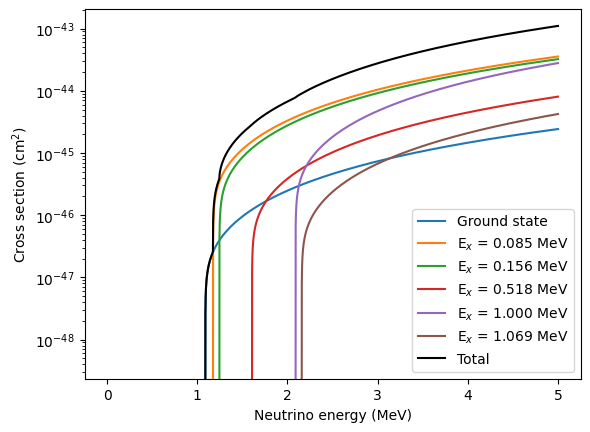

In [49]:
def xsWrite(E_nus,xs,name):
  outfile=open("outputs/{0}".format(name),"w")
  line=""
  for i in range(0,len(E_nus)):
    line+="{0:.3f},{1:.3e}".format(E_nus[i],xs[i])
    if not i==len(E_nus)-1:
      line+="\n"
  outfile.write(line)
  outfile.close()

total_xs=[0 for i in E_nus]
for ilev,level in enumerate(dict["product"]["levels"]):
  Ex = dict["product"]["levels"][ilev]
  if Ex>0:
    label="E$_x$ = {0:.3f} MeV".format(Ex)
  else:
    label="Ground state"
  plt.plot(E_nus,xs[ilev],label=label)
  outName="{0}_{1}.csv".format(baseName,ilev)
  xsWrite(E_nus,xs[ilev],outName)

  total_xs = np.add(total_xs,xs[ilev])

#Write total xs
outName="{0}_total.csv".format(baseName)
xsWrite(E_nus,total_xs,outName)

#Plot
plt.plot(E_nus,total_xs,label="Total",color='k')
plt.xlabel("Neutrino energy (MeV)")
plt.ylabel("Cross section (cm$^2$)")
plt.yscale("log")
plt.legend()
plt.savefig("plots/{0}_all_xs.png".format(baseName),dpi=400)
plt.show()

Now we load the neutrino spectra for calculating the flux-weighted cross sections. To do this, we load data and then interpolate so it matches our neutrino binning

In [50]:
#Spectrum obtained from https://www.awa.tohoku.ac.jp/~sanshiro/research/geoneutrino/spectrum/geoneutirno-lumonosity.knt
#These are integrated fluxes per keV per second over the entire Earth. Later, we reduce this to calculate the flux per cm2 on the surface
def loadGeoneutrinos(geoneutrinoSpectraFilename,E_nus):
  firstLine=8
  labels=["238U","232Th","235U","40K","87Rb","113Cd","115In","138La","176Lu","187Re"]
  read_fluxes=[[] for i in range(0,len(labels))]
  interpolated_fluxes=[[] for i in range(0,len(labels))]
  read_energies=[]
  for i,line in enumerate(open(geoneutrinoSpectraFilename,"r")):
    if i>=firstLine:
      if not line=="":
        line=line.strip("\n")
        lineParts=line.split()

        #Hardcoded dealing with differing bin width/normalization
        if i<110:
          binspacing=0.0001
        elif i<200:
          binspacing=0.001
        elif i<290:
          binspacing=0.01
        elif i<380:
          binspacing=0.1
        else:
          binspacing=1.

        read_energies.append(float(lineParts[0]))
        for j in range(1,len(lineParts)):
          read_fluxes[j-1].append(float(lineParts[j]))

  read_energies=np.array(read_energies)/1000. #Convert to MeV

  #Not interpolate to our target binning
  for i,f in enumerate(read_fluxes):
    interpolated_fluxes[i]=np.interp(E_nus,read_energies,read_fluxes[i],left=0,right=0)

  return interpolated_fluxes,labels

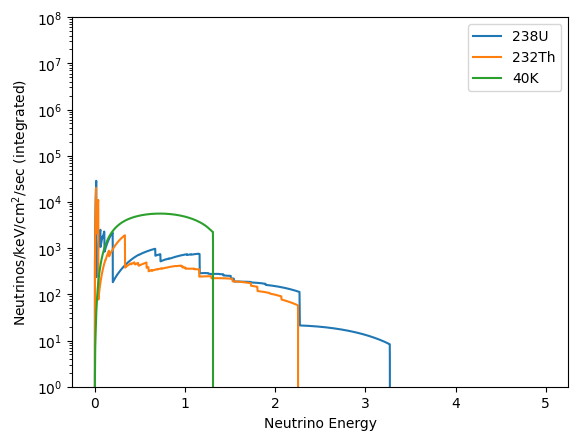

In [51]:
if fluxFlag==1:
  if dict["spectra"]["type"]=="geoneutrinos":
    geoneutrinoFluxes,labels=loadGeoneutrinos(geoneutrinoSpectraFilename,E_nus)
    
    #Normalize to per cm2 on Earth's surface
    R_earth_cm = R_earth*100.
    scaling = 1/(4*math.pi*math.pow(R_earth_cm,2))
    for i in range(0,len(geoneutrinoFluxes)):
      geoneutrinoFluxes[i]*=scaling

    for i,f in enumerate(geoneutrinoFluxes):
      if labels[i] in dict["spectra"]["sources"]:
        plt.plot(E_nus,f,label=labels[i])
    plt.legend()
    plt.yscale("log")
    plt.ylabel("Neutrinos/keV/cm$^2$/sec (integrated)")
    plt.ylim(1,1e8)
    plt.xlabel("Neutrino Energy")

    plt.savefig("plots/{0}_geospectrum.png".format(baseName),dpi=400)
    plt.show()
  elif dict["spectra"]["type"]=="reactor":
    print("TODO")
  else:
    print("Error")

  

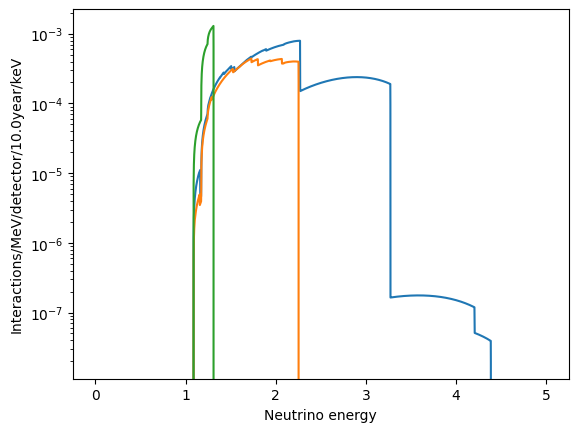

Total interactions from 238U per 10.0 year is 0.011
Total interactions from 232Th per 10.0 year is 0.010
Total interactions from 40K per 10.0 year is 0.109


In [52]:
if fluxFlag==1 and detectorFlag==1:
  sources=dict["spectra"]["sources"]
  weighted_fluxes = [[] for i in sources]
  for i,source in enumerate(sources):
    if source in labels:
      idx = labels.index(source)
      weighted_fluxes[i] = np.multiply(geoneutrinoFluxes[idx],total_xs)
      scaling=dict["detector"]["mass"]*dict["detector"]["fraction"]*dict["detector"]["molar_mass"]*dict["detector"]["abundance"]*86400*365*dict["detector"]["exposure"]
      weighted_fluxes[i]*=scaling*0.55
      plt.plot(E_nus,weighted_fluxes[i])

  plt.ylabel("Interactions/MeV/detector/{0}year/keV".format(dict["detector"]["exposure"]))
  plt.xlabel("Neutrino energy")
  plt.yscale("log")

  plt.savefig("plots/{0}_weightedSpectrum.png".format(baseName),dpi=400)
  plt.show()  

E_nus=np.array(E_nus)
if detectorFlag==1:
  for i,source in enumerate(sources):
    f = weighted_fluxes[i][(E_nus>1.176) & (E_nus<1.311)]
    sum=np.sum(f)
    print("Total interactions from {0} per {1} year is {2:.3f}".format(source,dict["detector"]["exposure"],sum))